<a href="https://colab.research.google.com/github/lomovtsevp/diploma_signature_verification/blob/main/diploma_signature_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

# zip_ref = zipfile.ZipFile("/content/drive/My Drive/signatures_cedar_bengalli.zip", 'r')
# zip_ref.extractall("/tmp")
# zip_ref.close()

!unzip '/content/drive/My Drive/signatures_cedar_bengalli.zip' -d 'data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/drive/My Drive/signatures_cedar_bengalli.zip
replace data/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-F-01.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
!ls '/content/data/BHSig260-Hindi/BHSig260-Hindi'

1    107  115  123  131  14   148  156	2   28	36  44	52  60	69  77	85  93
10   108  116  124  132  140  149  157	20  29	37  45	53  61	7   78	86  94
100  109  117  125  133  141  15   158	21  3	38  46	54  62	70  79	87  95
101  11   118  126  134  142  150  159	22  30	39  47	55  63	71  8	88  96
102  110  119  127  135  143  151  16	23  31	4   48	56  64	72  80	89  97
103  111  12   128  136  144  152  160	24  32	40  49	57  65	73  81	9   98
104  112  120  129  137  145  153  17	25  33	41  5	58  66	74  82	90  99
105  113  121  13   138  146  154  18	26  34	42  50	59  67	75  83	91
106  114  122  130  139  147  155  19	27  35	43  51	6   68	76  84	92


### Problem Statement
Signature is one of the most popular and commonly accepted biometric hallmarks that has been used since the ancient times for verifying different entities related to human beings, viz. documents, forms, bank checks, individuals, etc. Therefore, signature verification is a critical task and many efforts have been made to remove the uncertainty involved in the manual authentication procedure, which makes signature verification an important research line in the field of machine learning and pattern recognition. 


In this notebook, we model a writer independent **signature verification** task with a **convolutional Siamese network**.



In [3]:
#%tensorflow_version 2.x
import pandas as pd
import numpy as np
import tensorflow
tensorflow.__version__

'2.9.2'

In [4]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History

In [5]:
F  = 160 * 30
G = 160 * 24
F, G

(4800, 3840)

### Dataset Links:

https://drive.google.com/open?id=0B29vNACcjvzVc1RfVkg5dUh2b1E

### About the Dataset:


The BHSig260 signature dataset contains the signatures of 260 persons, among them 100 were signed in Bengali and 160 are signed in Hindi. 

For each of the signers, 24 genuine and 30 forged signatures are available. This results in 100 × 24 = 2, 400 genuine and 100 × 30 = 3, 000 forged signatures in Bengali, and 160 × 24 = 3, 840 genuine and 160×30 = 4, 800 forged signatures in Hindi.

In this task we are considering only Hindi singatures for easeness. 


**Paper Link:**  https://arxiv.org/pdf/1707.02131.pdf

In [6]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [7]:
# import osa
# os.chdir('/content/drive/My Drive/Deep Learning/GL/Siamese/')

In [8]:
# from zipfile import ZipFile
# with ZipFile('BHSig260.zip', 'r') as z:
#   z.extractall()

### Considering only Hindi signatures from the dataset.

In [9]:
path = "/content/data/BHSig260-Hindi/BHSig260-Hindi/"

In [10]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [11]:
dir_list

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 

In [12]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [13]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(160, 160)

In [14]:
orig_groups[0]

['/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-01.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-02.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-03.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-04.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-05.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-06.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-07.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-08.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-09.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-10.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-11.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-12.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-13.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-14.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-G-15.tif',
 '/content/data/BHSig260-

In [15]:
forg_groups[1]

['/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-01.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-02.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-03.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-04.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-05.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-06.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-07.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-08.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-09.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-10.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-11.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-12.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-13.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-14.tif',
 '/content/data/BHSig260-Hindi/BHSig260-Hindi/10/H-S-10-F-15.t

In [16]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [17]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [18]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [19]:
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [20]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [21]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [22]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = cv2.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

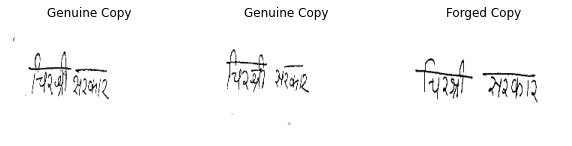

In [23]:
visualize_sample_signature()

In [24]:
120 

120

In [25]:
276 * 120

33120

In [26]:
276 * 120 + 24 * 12 *120

67680

In [27]:
24* 11 * 120

31680

In [28]:
24 * 12

288

In [29]:
(120 * 288) + (33120)

67680

In [30]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 , 12 * 23 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 276 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # 24*23/2=276 
        # Total no. of Genuine-Genuine pairs = 120 * 276(24*23/2) = 33120
        # Total number of Genuine-Forged pairs = 120 * 288 (24*20) = 34560
        # Total no. of data points = 33120 + 34560 = 67680
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        #print(len(orig_pairs),len(forg_pairs))
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        #print(pairs)
        targets=np.zeros((batch_size,))
        #print(targets)
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))
        
    return pairs, targets

In [31]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [32]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [33]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Explanation:
    When ytrue is 1, that means the sample are duplicates of each other, 
    so the Euclidean distance (ypred) between their outputs must be minimized.
    So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).
    When ytrue is 0, i.e. the samples are not duplicates, then the Euclidean distance 
    between them must be maximized, at least to the margin. So the loss to be minimized
    is the difference of the margin and the Euclidean distance - (margin - y_pred).
    If the Euclidean distance (ypred) is already greater than the margin, 
    then nothing is to be learned, so the loss is made to be zero in 
    that case by saying K.maximum(margin - y_pred, 0).
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [34]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((2,2), strides=(1,1)))  
    seq.add(Dropout(0.3))
    #seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((2,2), strides=(1,1)))
    seq.add(Dropout(0.3))
    #seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(512, kernel_size=(3, 3), activation='relu', name='conv3_1'))
    seq.add(MaxPooling2D((2,2), strides=(1,1)))
    seq.add(Dropout(0.3))
    #seq.add(ZeroPadding2D((1, 1)))
    
    #seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2'))    
    #seq.add(MaxPooling2D((2,2), strides=(1,1)))
    #seq.add(Dropout(0.3))
    #seq.add(Flatten(name='flatten'))
    seq.add(GlobalAveragePooling2D())
    seq.add(Dense(128, activation='relu'))
    return seq

In [35]:
input_shape=(img_h, img_w, 1)
input_shape

(155, 220, 1)

In [36]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [37]:
batch_sz = 128
num_train_samples = 276*120 + 24 * 12 *120
num_val_samples = num_test_samples = 276*20 + 288*20
num_train_samples, num_val_samples, num_test_samples

(67680, 11280, 11280)

In [38]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [39]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./signet.h5', verbose=1, save_weights_only=True),
    History()
]

In [40]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 10,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/10
528/528 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.8763
Epoch 1: saving model to ./signet.h5
528/528 [==============================] - 359s 665ms/step - loss: 0.1070 - accuracy: 0.8763 - val_loss: 0.1498 - val_accuracy: 0.8021 - lr: 1.0000e-04
Epoch 2/10
528/528 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9720
Epoch 2: saving model to ./signet.h5
528/528 [==============================] - 343s 650ms/step - loss: 0.0430 - accuracy: 0.9720 - val_loss: 0.1153 - val_accuracy: 0.8580 - lr: 1.0000e-04
Epoch 3/10
528/528 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9932
Epoch 3: saving model to ./signet.h5
528/528 [==============================] - 342s 647ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.1132 - val_accuracy: 0.8604 - lr: 1.0000e-04
Epoch 4/10
528/528 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9974
Epoch 4: saving model to ./signet.h5
528/528 [===

In [41]:
df_new = pd.DataFrame([1,2])
df_new.head()
df_new.to_csv("test.csv",index=False)

In [57]:
def plot_training(H, plotPath=None):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="center")
	#plt.savefig(plotPath)

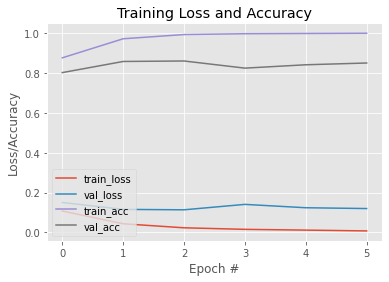

In [43]:
plot_training(results)

In [44]:
results

### Accuracy ROC

In [45]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [46]:
model.load_weights('final_model.h5')

In [47]:
import time
s = time.time()

Takes abiut 8-9 minutes to run, so be careful

In [61]:
test_gen = generate_batch(orig_test[0:2], forg_test[0:2], 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])
e =time.time()
print((e-s)/60," minutes")

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 26ms/step
32.39302320082982  minutes


In [104]:
pred_binarized = [1 if i <= threshold else 0 for i in pred]

In [105]:
# tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
# print(tr_acc, threshold)

from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(np.array(pred_binarized), np.array(tr_y)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86      5108
           1       0.93      0.83      0.87      6172

    accuracy                           0.87     11280
   macro avg       0.87      0.87      0.87     11280
weighted avg       0.88      0.87      0.87     11280



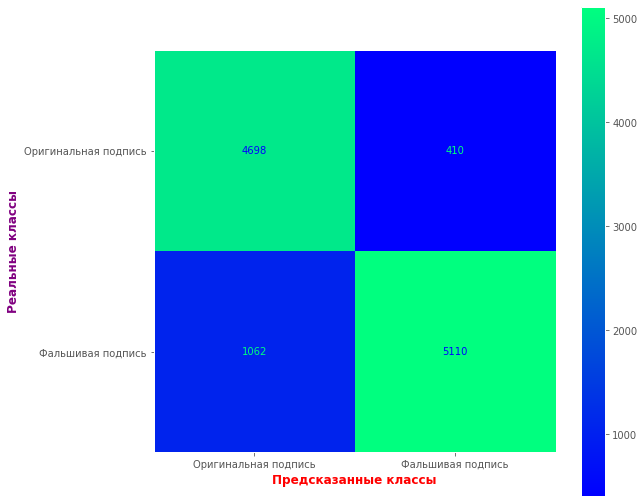

In [146]:
cm = confusion_matrix(pred_binarized, tr_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Оригинальная подпись', 'Фальшивая подпись'])
disp.plot(cmap='winter')
fig = disp.ax_.get_figure() 
fig.set_figwidth(9)
fig.set_figheight(9)
plt.grid(None)
plt.xlabel('Предсказанные классы', weight='bold', color='red')
plt.ylabel('Реальные классы',  weight='bold', color='purple')
plt.show()

#### Accuracy = 87% and Threshold = 0.31
Thus if the differnce score is less than 0.31, we predict the test image as Genuine and if the difference score is greater than 0.31, we predict it to be as forged

#### Below we see some sample results

In [50]:
test_gen = generate_batch(orig_test, forg_test, 1)
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

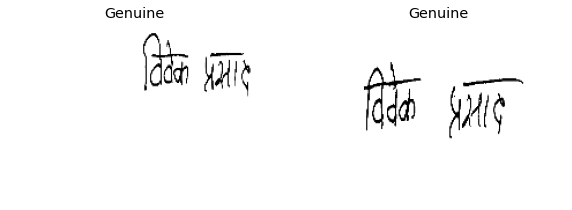

1/1 [==============================] - 0s 22ms/step
Difference Score =  0.48857048
Its a Forged Signature


In [51]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

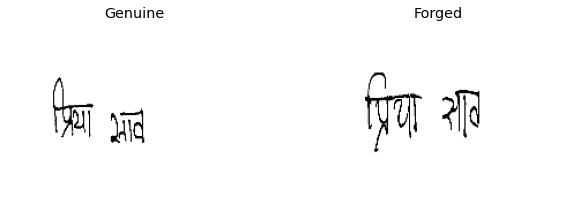

1/1 [==============================] - 0s 18ms/step
Difference Score =  0.54975456
Its a Forged Signature


In [52]:
predict_score()

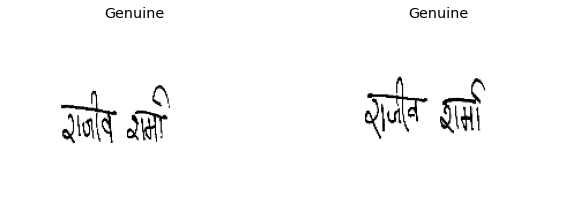

1/1 [==============================] - 0s 22ms/step
Difference Score =  0.12349436
Its a Genuine Signature


In [53]:
predict_score()

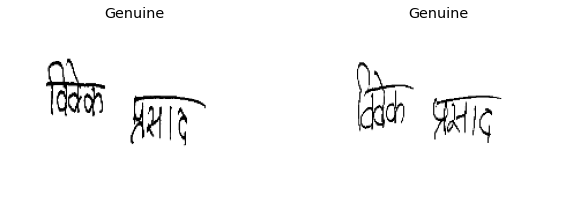

1/1 [==============================] - 0s 18ms/step
Difference Score =  0.34034866
Its a Forged Signature


In [54]:
predict_score()

### Lets us test my signature

1/1 [==============================] - 0s 20ms/step


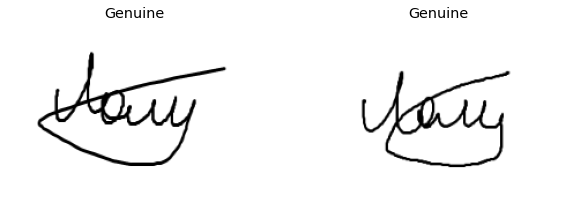

1/1 [==============================] - 0s 27ms/step
Difference Score =  0.26562673
Its a Genuine Signature


In [55]:
pairs=[np.zeros((1, img_h, img_w, 1)) for i in range(2)]
#targets=np.zeros((batch_size,))
img1 = cv2.imread("/content/реальная_ подпись.png", 0)
img2 = cv2.imread("/content/2022-12-11_14-19-37.png", 0)
img1 = cv2.resize(img1, (img_w, img_h))
img2 = cv2.resize(img2, (img_w, img_h))
img1 = np.array(img1, dtype = np.float64)
img2 = np.array(img2, dtype = np.float64)
img1 /= 255
img2 /= 255
img1 = img1[..., np.newaxis]
img2 = img2[..., np.newaxis]


pred, tr_y = [], []
tr_y = 1
model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])[0][0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
ax1.set_title('Genuine')
if tr_y == 1:
    ax2.set_title('Genuine')
else:
    ax2.set_title('Forged')
ax1.axis('off')
ax2.axis('off')
plt.show()
result = model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])
diff = result[0][0]
print("Difference Score = ", diff)
if diff > threshold:
    print("Its a Forged Signature")
else:
    print("Its a Genuine Signature")

(289, 1033) (289, 997)
1/1 [==============================] - 0s 21ms/step


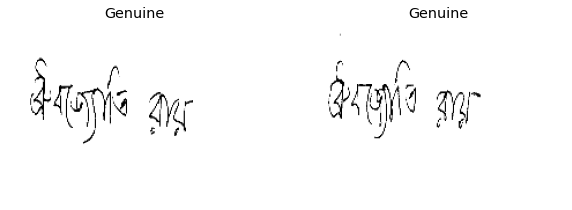

1/1 [==============================] - 0s 18ms/step
Difference Score =  0.16776532
Its a Genuine Signature


In [56]:
pairs=[np.zeros((1, img_h, img_w, 1)) for i in range(2)]
#targets=np.zeros((batch_size,))
img1 = cv2.imread("/content/data/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-G-01.tif", 0)
img2 = cv2.imread("/content/data/BHSig260-Bengali/BHSig260-Bengali/1/B-S-1-G-02.tif", 0)
tr_y = 1
img1 = np.array(img1, dtype = np.float64)
img2 = np.array(img2, dtype = np.float64)
print(img1.shape,img2.shape)
img1 = cv2.resize(img1, (img_w, img_h))
img2 = cv2.resize(img2, (img_w, img_h))
img1 = np.array(img1, dtype = np.float64)
img2 = np.array(img2, dtype = np.float64)
img1 /= 255
img2 /= 255
img1 = img1[..., np.newaxis]
img2 = img2[..., np.newaxis]


pred, tr_y = [], []

model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])[0][0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
ax1.set_title('Genuine')
if tr_y == 0:
    ax2.set_title('Genuine')
else:
    ax2.set_title('Genuine')
ax1.axis('off')
ax2.axis('off')
plt.show()
result = model.predict([np.expand_dims(img1, axis=0), np.expand_dims(img2, axis=0)])
diff = result[0][0]
print("Difference Score = ", diff)
if diff > threshold:
    print("Its a Forged Signature")
else:
    print("Its a Genuine Signature")